In [1]:
import pandas as pd
import os, gc, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import KFold
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


sys.path.append("../source/")
from helper_functions import *

In [2]:
useID = False

dl = DataLoader()
df_tr = dl.load_csv("train_transaction.csv")
df_tr_test = dl.load_csv("test_transaction.csv")

if useID:
    dl.transaction = False
    df_id = dl.load_csv("train_identity.csv")
    df_id_test = dl.load_csv("test_identity.csv")

    df_train = df_tr.merge(df_id, how='left', left_index=True, right_index=True)

    fix = {o:n for o, n in zip(df_id_test.columns, df_id.columns)}
    df_id.rename(columns=fix, inplace=True)
    df_test = df_tr_test.merge(df_id, how='left', left_index=True, right_index=True)

    del df_id, df_id_test, df_train, df_tr_test

else:
    df_train = df_tr
    df_test = df_tr_test
    del df_tr, df_tr_test

gc.collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 395 entries, TransactionID to TransactionDay
dtypes: bool(9), float32(377), int16(1), int32(2), int8(6)
memory usage: 863.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 394 entries, TransactionID to TransactionDay
dtypes: bool(9), float32(377), int16(1), int32(2), int8(5)
memory usage: 740.3 MB


0

In [4]:
df_train['D1n'] = np.floor(df_train["TransactionDay"] - df_train["D1"])
df_train['uid'] = df_train["card1"].astype(str)+'_'+df_train["addr1"].astype(str)+'_'+df_train["D1n"].astype(str)
df_train = df_train.drop(columns=["TransactionID"])

/tmp/ipykernel_18844/2139279300.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train['D1n'] = np.floor(df_train["TransactionDay"] - df_train["D1"])
/tmp/ipykernel_18844/2139279300.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train['uid'] = df_train["card1"].astype(str)+'_'+df_train["addr1"].astype(str)+'_'+df_train["D1n"].astype(str)


In [ ]:
# Create a variable for if many similar transactions happen in a row
# if card1 is the same, TransactionDT is the same, TransactionAmt, dist2? P_emailDomain? maybe all from the same card
df_train[df_train["isFraud"]==1].sort_values(by="TransactionAmt").iloc[50:70,0:20]

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4
454615,1,11633963,3.935,2,5365,177.0,185.0,1,224.0,0,NaN,NaN,NaN,0.0,1,2,3.0,15.0,0.0,1.0
557296,1,14749627,3.935,2,3154,408.0,185.0,1,224.0,1,NaN,NaN,NaN,74.0,0,0,2.0,2.0,0.0,1.0
343912,1,8471012,4.010,2,15885,545.0,185.0,2,138.0,1,NaN,NaN,NaN,89.0,0,0,1.0,2.0,0.0,2.0
343917,1,8471072,4.010,2,15885,545.0,185.0,2,138.0,1,NaN,NaN,NaN,89.0,0,0,1.0,2.0,0.0,2.0
179628,1,3950612,4.081,2,8755,500.0,185.0,1,224.0,0,NaN,NaN,NaN,NaN,0,0,1.0,2.0,0.0,1.0
545040,1,14393298,4.109,2,1191,555.0,191.0,2,102.0,0,NaN,NaN,NaN,NaN,0,0,2.0,2.0,0.0,2.0
38805,1,948445,4.431,2,10876,104.0,185.0,2,137.0,0,NaN,NaN,NaN,NaN,0,0,1143.0,1490.0,0.0,636.0
310999,1,7748167,4.471,2,13832,375.0,185.0,1,224.0,1,NaN,NaN,NaN,40.0,0,0,1.0,1.0,0.0,1.0
195434,1,4398349,4.547,2,9917,142.0,185.0,2,138.0,1,NaN,NaN,NaN,NaN,5,1,1.0,8.0,0.0,2.0
140191,1,2861726,4.547,2,3154,408.0,185.0,1,224.0,1,NaN,NaN,NaN,NaN,5,1,12.0,34.0,0.0,2.0


In [24]:
tmp = df_train[df_train["card1"]==12184]
tmp[tmp["TransactionAmt"]==4.652]

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V333,V334,V335,V336,V337,V338,V339,TransactionDay,D1n,uid
343324,1,8461439,4.652,2,12184,440.0,185.0,2,138.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.933319,6.0,12184_nan_6.0


In [ ]:
# Encode the most important columns

copy = df_train.copy()
encode_columns = ["TransactionAmt","C13","P_emaildomain","C11","card2","D15","card1","D2","D1","D10"]
encode_AG(encode_columns, ["uid"], df_train, copy, aggregations=["mean"])
del copy
# df_train = df_train.drop(columns=['uid'])

/home/alex/Research/FindingFraudsters/FindingFraudsters/notebooks/../source/helper_functions.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  
/home/alex/Research/FindingFraudsters/FindingFraudsters/notebooks/../source/helper_functions.py:125: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/

'TransactionAmt_uid_mean' , 

/home/alex/Research/FindingFraudsters/FindingFraudsters/notebooks/../source/helper_functions.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  
/home/alex/Research/FindingFraudsters/FindingFraudsters/notebooks/../source/helper_functions.py:125: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/

'C13_uid_mean' , 

/home/alex/Research/FindingFraudsters/FindingFraudsters/notebooks/../source/helper_functions.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  
/home/alex/Research/FindingFraudsters/FindingFraudsters/notebooks/../source/helper_functions.py:125: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/

'P_emaildomain_uid_mean' , 

/home/alex/Research/FindingFraudsters/FindingFraudsters/notebooks/../source/helper_functions.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  
/home/alex/Research/FindingFraudsters/FindingFraudsters/notebooks/../source/helper_functions.py:125: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/

'C11_uid_mean' , 

/home/alex/Research/FindingFraudsters/FindingFraudsters/notebooks/../source/helper_functions.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  
/home/alex/Research/FindingFraudsters/FindingFraudsters/notebooks/../source/helper_functions.py:125: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/

'card2_uid_mean' , 

/home/alex/Research/FindingFraudsters/FindingFraudsters/notebooks/../source/helper_functions.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  
/home/alex/Research/FindingFraudsters/FindingFraudsters/notebooks/../source/helper_functions.py:125: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/

'D15_uid_mean' , 

/home/alex/Research/FindingFraudsters/FindingFraudsters/notebooks/../source/helper_functions.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  
/home/alex/Research/FindingFraudsters/FindingFraudsters/notebooks/../source/helper_functions.py:125: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/

'card1_uid_mean' , 

/home/alex/Research/FindingFraudsters/FindingFraudsters/notebooks/../source/helper_functions.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  
/home/alex/Research/FindingFraudsters/FindingFraudsters/notebooks/../source/helper_functions.py:125: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/

'D2_uid_mean' , 

/home/alex/Research/FindingFraudsters/FindingFraudsters/notebooks/../source/helper_functions.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  
/home/alex/Research/FindingFraudsters/FindingFraudsters/notebooks/../source/helper_functions.py:125: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/

'D1_uid_mean' , 'D10_uid_mean' , 

/home/alex/Research/FindingFraudsters/FindingFraudsters/notebooks/../source/helper_functions.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  
/home/alex/Research/FindingFraudsters/FindingFraudsters/notebooks/../source/helper_functions.py:125: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/

In [29]:
df_train

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card4,card6,P_emaildomain,R_emaildomain,C2,...,V270,V325,V326,V327,V334,V335,V336,V337,V338,V339
0,0,86400,68.500000,0,13926,0,0,-1,-1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,86401,29.000000,0,2755,1,0,0,-1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,86469,59.000000,0,4663,2,1,1,-1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,86499,50.000000,0,18132,1,1,2,-1,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,86506,50.000000,1,4497,1,0,0,-1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0,15811047,49.000000,0,6550,2,1,-1,-1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,0,15811049,39.500000,0,10444,1,1,0,-1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,0,15811079,30.950001,0,12037,1,1,0,-1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,0,15811088,117.000000,0,7826,1,1,7,-1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
target_col = 'isFraud'
input_cols =  [f'C{i}' for i in range(1, 6)]
df_train = remove_correlated_columns(df_train, input_cols, target_col, False)

In [13]:
# Look at correlation between variables which are sparsely populated
"""
Many variables are sparsley populated. And many appear to be sparsley populated in the same way.
For variables which are sparsley populated in the same way, find out which ones are correlated with each other.
Of the ones which are highly correlated, only keep the one which is most highly correlated with isFraud.
Alternatively: Only keep the one which  has the most unique values
"""
# Organize columns which are equally sparsley populated
cols = []
col_dict = {}
for col in df_train.columns:
    total_nan = int(df_train[col].isna().sum())
    percent_pop = (len(df_train) - df_train[col].isna().sum()) / len(df_train) *100 # percent of rows which are not NaN
    percent_pop = round(percent_pop, 2)
    
    if not percent_pop in col_dict.keys():
        col_dict[percent_pop] = []

    col_dict[percent_pop].append(col)
    # print( percent_pop, f" % of rows contain values for {col}")
    
vars_to_keep = []
for percent in col_dict.keys():
    if percent < 50 and len(col_dict[percent]) > 1:
        df_subset = df_train[col_dict[percent]]
        df_subset = remove_correlated_columns(df_subset, col_dict[percent], keep_corr=False)
        vars_to_keep += list(df_subset.columns)
    else:
        vars_to_keep += col_dict[percent]

df_train = df_train[vars_to_keep]

In [14]:
target_col = 'isFraud'
v_columns = [str(col) for col in df_train.columns if str(col).startswith("V")]
df_train = remove_correlated_columns(df_train, v_columns, target_col, False)

In [62]:
# Fill NaN for V columns with mean values
v_columns = [str(col) for col in df_train.columns if str(col).startswith("V")]
df_train = df_train.fillna(df_train[v_columns].mean())


In [19]:
from sklearn.model_selection import train_test_split

y = df_train["isFraud"]
X = df_train.drop(columns=["isFraud"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [24]:
params = {"device":"cuda", "objective":"binary:logistic",
                "eval_metric":"logloss",
                'learning_rate': 0.05,
                'max_depth': 5, }

dtrain = xgb.DMatrix(X, label=y) 
dval = xgb.DMatrix(X_test, label=y_test)

model = xgb.train(params, dtrain, num_boost_round=100)
importance = model.get_score(importance_type='gain')

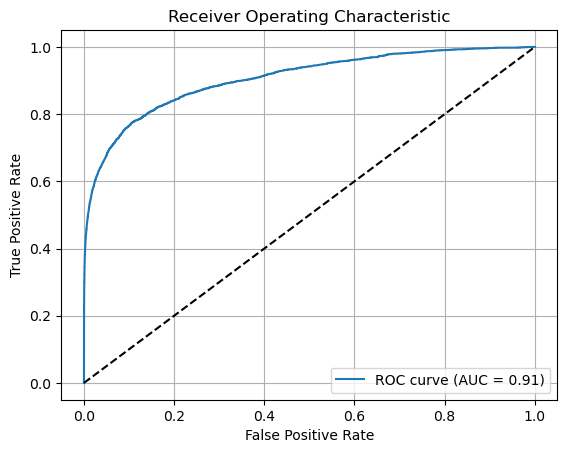

In [25]:
prob = model.predict(dval)
 
# Compute ROC curve and AUC
fpr, tpr, threshold = roc_curve(y_test.astype(int).values, prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [26]:
importance

{'TransactionDT': 76.15872192382812,
 'TransactionAmt': 118.04943084716797,
 'ProductCD': 111.4242172241211,
 'card1': 75.85995483398438,
 'card4': 77.70764923095703,
 'card6': 427.6397705078125,
 'P_emaildomain': 157.20993041992188,
 'R_emaildomain': 152.82040405273438,
 'C2': 277.05548095703125,
 'C3': 67.40849304199219,
 'C5': 412.2474670410156,
 'C6': 191.5977783203125,
 'C7': 277.22296142578125,
 'C8': 1036.1556396484375,
 'C9': 161.66180419921875,
 'C10': 129.7134246826172,
 'C11': 373.1414489746094,
 'C12': 431.7113037109375,
 'C13': 236.9716796875,
 'C14': 785.436767578125,
 'V284': 22.81070899963379,
 'V286': 60.13251876831055,
 'V290': 81.04769134521484,
 'V292': 28.059364318847656,
 'V310': 97.44253540039062,
 'V312': 377.3655090332031,
 'V319': 40.53702926635742,
 'V320': 117.8537368774414,
 'TransactionAmt_uid_mean': 43.402374267578125,
 'C13_uid_mean': 58.317081451416016,
 'P_emaildomain_uid_mean': 76.65145111083984,
 'C11_uid_mean': 28.025922775268555,
 'card2_uid_mean':

In [27]:
importance_df = pd.DataFrame(importance,index=range(1))
importance_df.sort_values(by=0,axis=1,ascending=False)

,V258,V201,addr2,V225,V283,V90,C8,V69,C14,V29,...,V173,V23,V7,V161,V183,V85,V43,V166,V278,V228
0,5066.358887,4126.203125,2749.622803,1694.314697,1294.070068,1124.126099,1036.15564,868.463623,785.436768,748.973999,...,9.652006,6.240669,6.096161,5.897507,5.241121,4.295656,3.042401,1.928753,1.392637,0.144245


In [28]:
importance_df.columns[0:10]

Index(['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card4',
       'card6', 'P_emaildomain', 'R_emaildomain', 'C2', 'C3'],
      dtype='object')

In [69]:
pred = prob > optimal_threshold

pred = (pred == 1).astype(int)

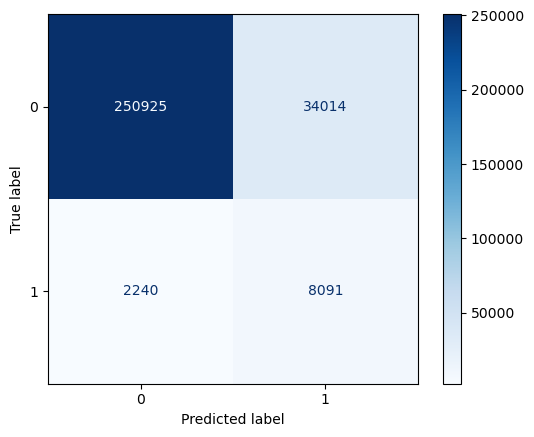

In [70]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')

In [ ]:
# Isolation doesn't work, because individual instances are not isFraud! 
# we need to try to group uinque cards together and make aggregate features
# Then predict which cards are outliers


clf = IsolationForest().fit(X)
pred = clf.predict(X_test)

In [50]:
pred = (pred == -1).astype(int) # -1 is an outlier, but in our data 1 == isFraud


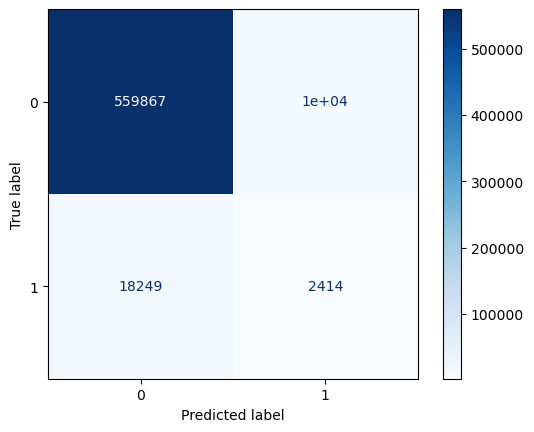

In [ ]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')

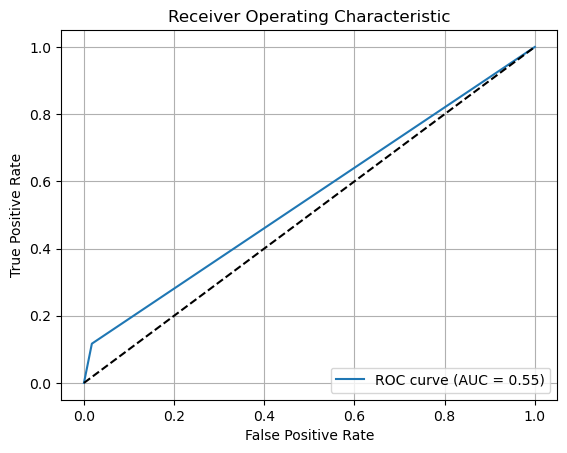

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()